<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [GTS4] - CNN with GTSRB dataset - Data augmentation 
<!-- DESC --> Episode 4 : Improving the results with data augmentation
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - Trying to improve training by **enhancing the data**
  - Using Keras' **data augmentation utilities**, finding their limits...
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset


## What we're going to do :
 - Increase and improve the training dataset
 - Identify the limits of these tools

## Step 1 - Import and init
### 1.1 - Python

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import numpy as np
import h5py

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
import os, sys, time, random

from importlib import reload

sys.path.append('..')
import fidle.pwk as ooo

ooo.init()


FIDLE 2020 - Practical Work Module
Version              : 0.4.3
Run time             : Friday 28 February 2020, 14:23:29
TensorFlow version   : 2.0.0
Keras version        : 2.2.4-tf


### 1.2 - Where are we ? 

In [2]:
place, dataset_dir = ooo.good_place( { 'GRICAD' : f'{os.getenv("SCRATCH_DIR","")}/PROJECTS/pr-fidle/datasets/GTSRB',
                                       'IDRIS'  : f'{os.getenv("WORK","")}/datasets/GTSRB',
                                       'HOME'   : f'{os.getenv("HOME","")}/datasets/GTSRB'} )

Well, we should be at GRICAD !
We are going to use: /bettik/PROJECTS/pr-fidle/datasets/GTSRB


## Step 2 - Dataset loader
Dataset is one of the saved dataset: RGB25, RGB35, L25, L35, etc.  
First of all, we're going to use a smart dataset : **set-24x24-L**  
(with a GPU, it only takes 35'' compared to more than 5' with a CPU !)

In [3]:
%%time

def read_dataset(dataset_dir, name):
    '''Reads h5 dataset from dataset_dir
    Args:
        dataset_dir : datasets dir
        name        : dataset name, without .h5
    Returns:    x_train,y_train,x_test,y_test data'''
    # ---- Read dataset
    filename=f'{dataset_dir}/{name}.h5'
    with  h5py.File(filename,'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_test  = f['x_test'][:]
        y_test  = f['y_test'][:]

    # ---- done
    print('Dataset "{}" is loaded. ({:.1f} Mo)\n'.format(name,os.path.getsize(filename)/(1024*1024)))
    return x_train,y_train,x_test,y_test


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs


## Step 3 - Models
We will now build a model and train it...

This is my model ;-) 

In [4]:
# A basic model
#
def get_model_v1(lx,ly,lz):
    
    model = keras.models.Sequential()
    
    model.add( keras.layers.Conv2D(96, (3,3), activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(192, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1500, activation='relu'))
    model.add( keras.layers.Dropout(0.5))

    model.add( keras.layers.Dense(43, activation='softmax'))
    return model

## Step 4 - Callbacks  
We prepare 2 kind callbacks :  TensorBoard and Model backup

In [6]:
ooo.mkdir('./run/models')
ooo.mkdir('./run/logs')

# ---- Callback tensorboard
log_dir = "./run/logs/tb_" + ooo.tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = "./run/models/best-model.h5"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = "./run/models/model-{epoch:04d}.h5"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

## Step 5 - Load and prepare dataset
### 5.1 - Load

In [7]:
x_train,y_train,x_test,y_test = read_dataset(dataset_dir,'set-24x24-L')

Dataset "set-24x24-L" is loaded. (228.8 Mo)



### 5.2 - Data augmentation

In [8]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)
datagen.fit(x_train)

## Step 6 - Train the model
**Get the shape of my data :**

In [9]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

Images of the dataset have this folowing shape :  (24, 24, 1)


**Get and compile a model, with the data shape :**

In [10]:
model = get_model_v1(lx,ly,lz)

# model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train it :**  
Note : La courbe d'apprentissage est visible en temps réel avec Tensorboard :    
`#tensorboard --logdir ./run/logs`  

In [11]:
%%time

batch_size = 64
epochs     = 10

# ---- Shuffle train data
#x_train,y_train=ooo.shuffle_np_dataset(x_train,y_train)

# ---- Train
#
history = model.fit(  datagen.flow(x_train, y_train, batch_size=batch_size),
                      steps_per_epoch = int(x_train.shape[0]/batch_size),
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_test, y_test),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save('./run/models/last-model.h5')

Train for 612 steps, validate on 12630 samples
Epoch 1/10
612/612 [==============================] - 15s 24ms/step - loss: 2.1205 - accuracy: 0.4047 - val_loss: 0.8360 - val_accuracy: 0.7512
Epoch 2/10
612/612 [==============================] - 12s 20ms/step - loss: 0.9110 - accuracy: 0.7209 - val_loss: 0.4255 - val_accuracy: 0.8871
Epoch 3/10
612/612 [==============================] - 12s 20ms/step - loss: 0.6064 - accuracy: 0.8142 - val_loss: 0.3533 - val_accuracy: 0.9116
Epoch 4/10
612/612 [==============================] - 12s 20ms/step - loss: 0.4648 - accuracy: 0.8560 - val_loss: 0.2755 - val_accuracy: 0.9246
Epoch 5/10
612/612 [==============================] - 12s 20ms/step - loss: 0.3765 - accuracy: 0.8824 - val_loss: 0.2727 - val_accuracy: 0.9295
Epoch 6/10
612/612 [==============================] - 13s 20ms/step - loss: 0.3227 - accuracy: 0.8989 - val_loss: 0.2075 - val_accuracy: 0.9487
Epoch 7/10
612/612 [==============================] - 12s 20ms/step - loss: 0.2795 - accu

**Evaluate it :**

In [12]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9509


In [13]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.1811
Test accuracy  : 0.9509


## Step 7 - History
The return of model.fit() returns us the learning history

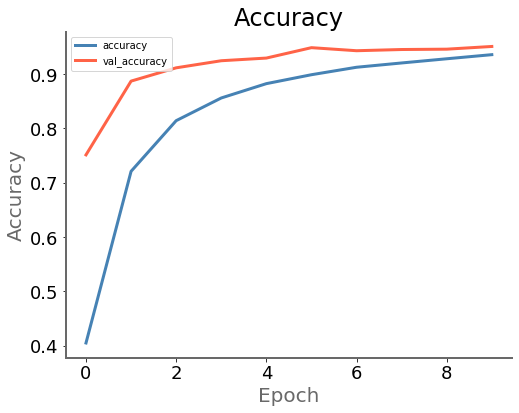

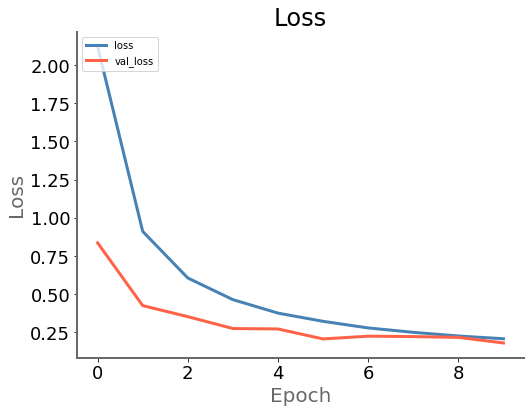

In [14]:
ooo.plot_history(history)

## Step 8 - Evaluate best model

### 8.1 - Restore best model :

In [15]:
loaded_model = tf.keras.models.load_model('./run/models/best-model.h5')
# best_model.summary()
print("Loaded.")

Loaded.


### 8.2 - Evaluate it :

In [16]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.1811
Test accuracy  : 0.9509


**Plot confusion matrix**

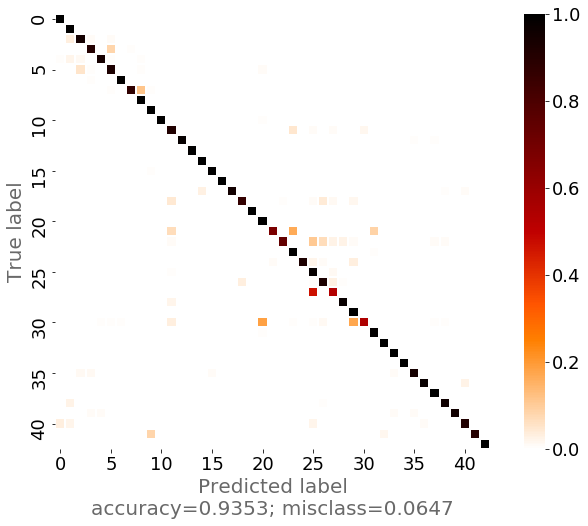

In [18]:
y_pred   = model.predict_classes(x_test)
conf_mat = confusion_matrix(y_test,y_pred, normalize="true", labels=range(43))

ooo.plot_confusion_matrix(conf_mat,annot=False)

<div class="todo">
     What you can do:
    <ul>
        <li>Try different datasets / models</li>
        <li>Test different hyperparameters (epochs, batch size, optimization, etc.)</li>
        <li>What's the best strategy?  How to compare?</li>
    </ul>
    
</div>

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>